# Tutorial: Simulation of Information Diffusion in Social Networks 

### Discussion 

 -  Focus on Predictive Models 
 -  LT vs Independent Cascade vs Linear Influence 
 - 

# Background

## Setup


In [1]:
import graph_tool as gt 
from graph_tool import generation, draw, Graph
import numpy as np
import os 
import copy
#Required to get matplotlib and graph-tool to play nice 
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
import matplotlib.pyplot as plt 
%matplotlib inline 
import random 

l = 0.01 # vary between 0 (no connections) and 1 (all connected) 
n = 1000  # Number of Nodes 
c = 10 # Communities (SBM Only)

# Function used for community networks 
def group_mem_prob(a, b): 
    if a == b: 
        return 0.995 # Increase for tighter communities 
    else: 
        return 0.005 # increase for looser communities 

# Get graph positions using SFDP layouts with common parameters 
def get_positions(graph): 
    pos = draw.sfdp_layout(graph, mu = 1.0, mu_p = 1.0, 
                           gamma=5.0, C= 5.0, p=0.1, max_level=20)
    return pos 

# Draw graph with thin edges and certain properties 
# Optionally specify an output file 
# Must specify to_file=True to get it to work with saving to file.  
def draw_graph(graph, 
               pos = None, 
               to_file = False, 
               vertex_fill_color=None, 
               folder = "", 
               file="graph"): 
    degs = graph.degree_property_map("out")
    degs.a = 2 * np.sqrt(degs.a)
    if pos == None: 
        pos = get_positions(graph) 
    
    if folder != "": 
        path = folder + "/" + file + ".png" 
    else: 
        path = "./" + file + ".png"
    if to_file: 
        draw.graph_draw(graph, output = path, 
                  vertex_size = degs,
                  vertex_fill_color = vertex_fill_color, 
                  pos=pos, edge_color="black", edge_pen_width=0.08)
    else: 
        draw.graph_draw(graph, inline=True, 
            vertex_size = degs,
            vertex_fill_color = vertex_fill_color, 
            pos=pos, edge_color="black", edge_pen_width=0.08)

/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


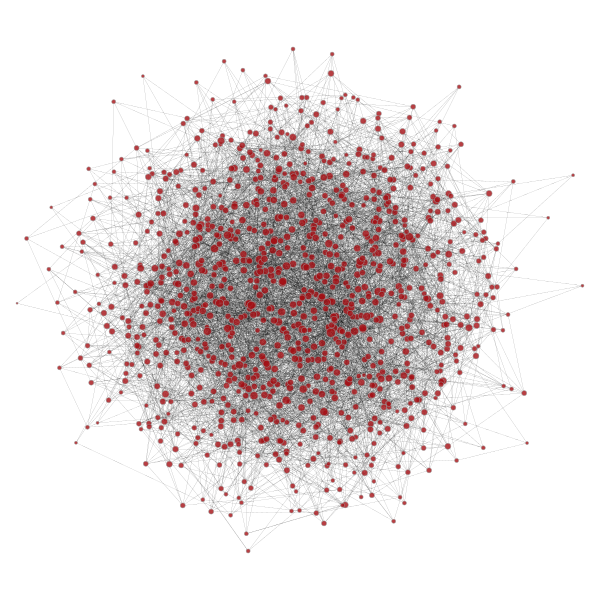

In [2]:
erdos_renyi = generation.random_graph(n, lambda: np.random.poisson((n-1) * l), directed=False, model="erdos") 
draw_graph(erdos_renyi)

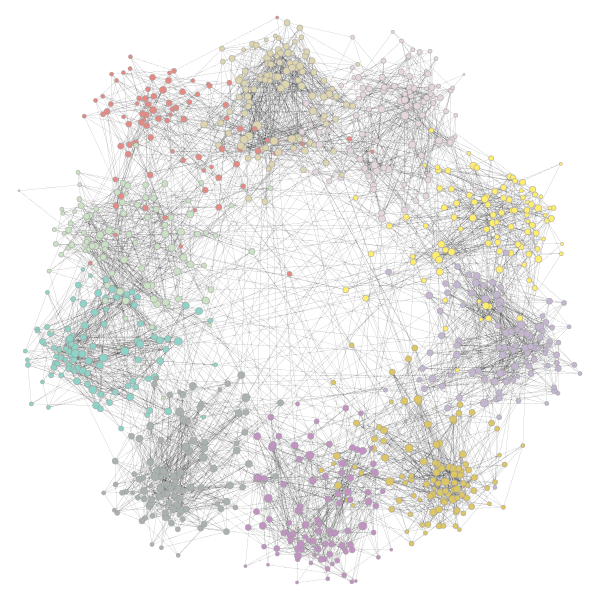

In [3]:
sbm, bm = generation.random_graph(n, lambda: np.random.poisson(c), 
                           directed = False, 
                           model="blockmodel", 
                           block_membership = lambda: np.random.randint(c), 
                           edge_probs = group_mem_prob)
draw_graph(sbm, vertex_fill_color=bm)

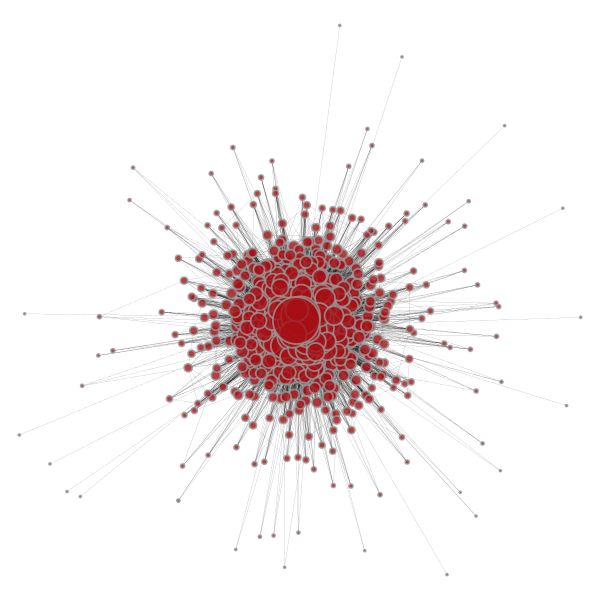

In [4]:
# Random graph from https://www.pnas.org/content/pnas/99/suppl_1/2566.full.pdf - paper on random graphs for social networks (2002)
# Exponential Dist. of Degrees 

exp_graph = generation.random_graph(n, lambda: int(np.random.exponential(1/(l))) + 1, directed=False)
draw_graph(exp_graph)

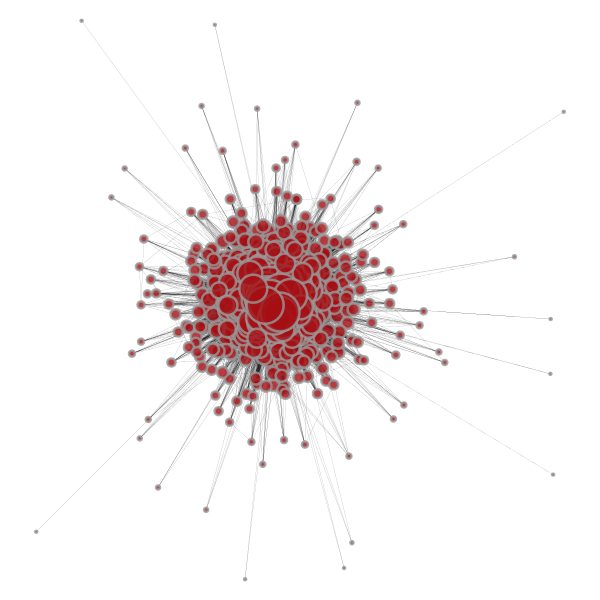

In [5]:
# Real-Life networks are Power-Law distributed 
power_graph = generation.random_graph(n, lambda: int(n * (1 - np.random.power(4))) + 1, directed=False)
draw_graph(power_graph)

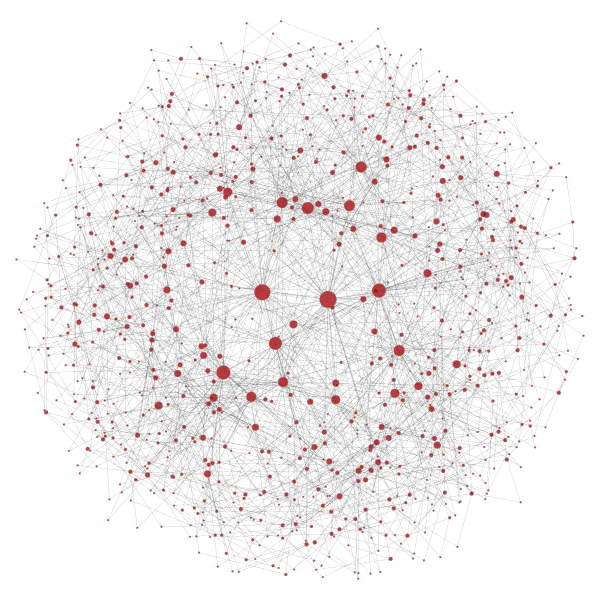

In [6]:
# Barabási–Albert is the go-to for this  
barabasi_albert = generation.price_network(n, m=2, directed=False)
draw_graph(barabasi_albert)

# Epidemiological Models
## Background 
Several Disease-Based Models 
 - SI (Susceptible-Infected) 
 - SIS (Susceptible-Infected-Susceptible) 
 - SIR  (Susceptible-Infected-Recovered) 
 - SIRS  (Susceptible-Infected-Recovered-Susceptible) 
 - SEIR (Susceptible-Exposed-Infected-Recovered)
 - S-SEIR (Single Layer 
Susceptible-Exposed-Infected-Recovered) 
 - SCIR (Susceptible-Contacted-Infected-Recovered) 
 - irSIR (SIR with infection recovery mechanism) 
 - FSIR (Flooding Susceptible-Infected-Recovered) 
 - ESIS (Emotional Susceptible-Infected-Susceptible) 

 The first several models (SI, SIS, SIR, SIRS) are not widely used as they are quite basic and not as performant for social networks. We select a few more interesting ones 
 - SEIR/SCIR, which are similar because "exposed" is close to "contacted" 
 - FSIR, which considers degraded spreading with too much information exposure 
 - irSIR which considers views will be adopted and abandoned 

 

In [25]:
import random 
class SIRS: 
    S = [1, 1, 1, 1] # Susceptible are white 
    I = [0, 0, 0, 1] # Infected are Black 
    R = [0.5, 0.5, 0.5, 1] # Recovered are Grey +
    def __init__(self, graph): 
        ''' 
        Set up the model. Creates an internal copy of the graph, 
        and sets up maps to keep track of our parameters. 
        
        Keep a state reference. 
        '''
        self.g = graph.copy() 
        self.pos = get_positions(self.g) 
        self.lam = self.g.new_edge_property("double") 
        self.mu = self.g.new_vertex_property("double") 
        self.a = self.g.new_vertex_property("double") 
        self.state = self.g.new_vertex_property("vector<double>")
        self.vs = self.g.get_vertices() 
    
    def reset(self, lam = 0.1, mu = 0.05, a = 0.5, infected_patients = [0]): 
        ''' 
        Set Lambda, Mu, and Alpha to their starting states. 
        Also, set up which patients are infected. 
        '''
        self.lam.a = lam
        self.mu.a = mu 
        self.a.a = a 
        for v in self.g.vertices(): 
            self.state[v] = SIRS.S 
        for patient in infected_patients: 
            self.state[patient] = SIRS.I 
    
    def infected(self, v): 
        ''' 
        Returns [
            new_susceptible, 
            new_infected, 
            new_recovers 
        ]
        '''
        # try to infect edges 
        new_infects = set() 
        new_recovers = set() 
        for edge in self.g.get_out_edges(v): 
            if self.state[edge[-1]] == SIRS.S: #if they are susceptible... 
                if random.random() < self.lam[self.g.edge(*edge)]: 
                    new_infects.add(edge[-1])
        if random.random() < self.mu[v]: 
            new_recovers.add(v)
        
        return [set(), new_infects, new_recovers]
    def susceptible(self): 
        ''' 
        Returns [
            new_susceptible, 
            new_infected, 
            new_recovers 
        ]
        '''
        return [set(), set(), set()]
    def recovered(self): 
        ''' 
        Returns [
            new_susceptible, 
            new_infected, 
            new_recovers
        ]
        '''
    def step(self): 
        new_infects = set() 
        new_recovers = set() 
        new_susceptibles = set() 
        for v in self.vs: 
            if self.state[v] == SIRS.S: 
                ns, ni, nr = self.susceptible(v) 
                new_infects.update(ni) 
                new_susceptibles.update(ns) 
                new_recovers.update(nr) 
            if self.state[v] == SIRS.I:
                ns, ni, nr = self.infected(v) 
                new_infects.update(ni) 
                new_susceptibles.update(ns) 
                new_recovers.update(nr) 

            # Recover people 
            if self.state[v] == SIRS.R: 
                ns, ni, nr = self.recovered(v) 
                new_infects.update(ni) 
                new_susceptibles.update(ns) 
                new_recovers.update(nr) 

        for v in new_infects: 
            state[v] = SIRS.I 
        for v in new_recovers: 
            state[v] = SIRS.R 
        for v in new_susceptibles: 
            state[v] = SIRS.S 
        return new_susceptibles, new_infects, new_recovers
    
    def run(self, logging_handler, steps = 100): 
        ''' 
        Logging Handler should setup and on a .log() call accept new_suseptible, new_infected, new_recovered. 
        '''
        logging_handler.setup(self.g, steps) 
        for i in range(steps): 
            logging_handler.log(i, *self.step())
    
class LoggingHandler: 
    def setup(self, g, steps): 
        self.g = g 
        self.d = np.zeros((steps, 3)) 
        self.counts = np.zeros((steps, 3)) 
    def log(self, step, ns, ni, nr): 
        self.d[s, 0] = len(new_sus) - len(new_inf)
        self.d[s, 1] = len(new_inf) - len(new_rec)
        self.d[s, 2] = len(new_rec) - len(new_sus)

In [26]:
# We're ready to run our simulation 
sirs = SIRS(barabasi_albert)
sirs.reset(lam = 0.1, 
           mu = 0.05, 
           a = 0.5, 
           infected_patients = [0]
)
logger = LoggingHandler() 
sirs.run(logger, 100)

TypeError: unsupported operand type(s) for +=: 'set' and 'set'

In [0]:
import random 
### BASIC SIRS SIMULATION ### 

# First, we create a copy of the graph we want to run simulations on
g = barabasi_albert.copy()
pos = get_positions(g)
# Set up infection variables 
lam = g.new_edge_property("double")  # it goes along edges
mu = g.new_vertex_property("double") # Vertex property because per individual 
a = g.new_vertex_property("double")  # Vertex Property because per individual 
state = g.new_vertex_property("vector<double>") # Keep track of S/I/R


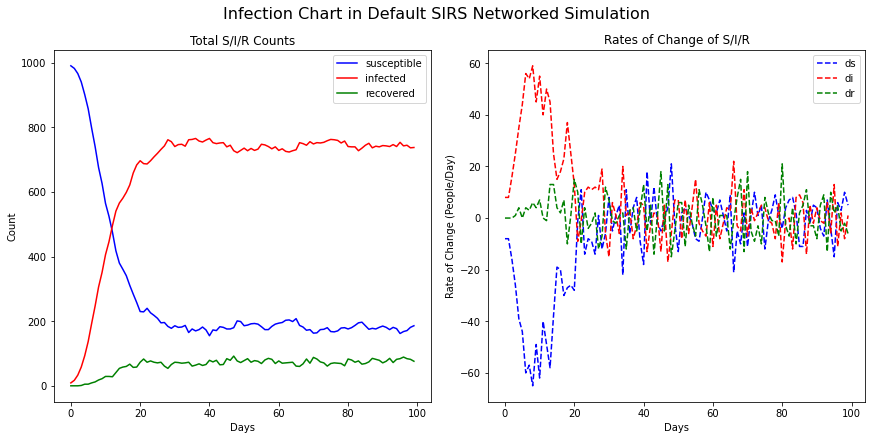

In [0]:

lam.a = 0.1  # Set lambda to 0.5 
mu.a = 0.05 # Recovery Rate 
a.a = 0.5 # Recovered Users who become susceptible again 



def do_SIRS_simulation(g, PATIENT_ZEROS, state, lam, mu, a, pos, steps = 1000): 
    ''' 
    Resource: https://www.nature.com/articles/s41598-018-24648-w
    https://link.springer.com/chapter/10.1007/978-3-642-02466-5_78
    '''
    S = [1, 1, 1, 1] # Susceptible are white 
    I = [0, 0, 0, 1] # Infected are Black 
    R = [0.5, 0.5, 0.5, 1] # Recovered are Grey 

    # Set everyone to susceptible 
    for v in g.vertices(): 
        state[v] = S 

    # Infect Patients 0 
    for patient in PATIENT_ZEROS: 
        state[patient] = I

    vs = g.get_vertices()
    def step(): 
        new_infects = set() 
        new_recovers = set() 
        new_susceptibles = set() 
        for v in vs: 
            if state[v] == I: 
                # try to infect edges 
                for edge in g.get_out_edges(v): 
                    if state[edge[-1]] == S: #if they are susceptible... 
                        if random.random() < lam[g.edge(*edge)]: 
                            new_infects.add(edge[-1])
                # try to heal
                # Model basics is Infection 
                # Recovery is a bonus, so abstract it out 
                
                if random.random() < mu[v]: 
                    new_recovers.add(v)
            # Recover people 
            if state[v] == R: 
                if random.random() < a[v]: 
                    new_susceptibles.add(v) 
        for v in new_infects: 
            state[v] = I 
        for v in new_recovers: 
            state[v] = R 
        for v in new_susceptibles: 
            state[v] = S 
        return new_susceptibles, new_infects, new_recovers 
    
    # save animation 
    # if not os.path.exists("./frames"): 
    #     os.mkdir("./frames")

    counts = np.zeros((steps, 3)) 
    
    ds = []
    di = []
    dr = []
    for s in range(steps): 
        new_sus, new_inf, new_rec = step() 
        counts[s, 0] = sum(1 for v in g.get_vertices() if state[v] == S)
        counts[s, 1] = sum(1 for v in g.get_vertices() if state[v] == I)
        counts[s, 2] = sum(1 for v in g.get_vertices() if state[v] == R)
        ds.append(len(new_sus) - len(new_inf))
        di.append(len(new_inf) - len(new_rec))
        dr.append(len(new_rec) - len(new_sus))
    
    return counts, np.stack((ds, di, dr), axis=1)

counts, dcounts = do_SIRS_simulation(g, [0], state, lam, mu, a, pos, 100)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 6), constrained_layout="True") 
x = list(range(100)) 
ax1.plot(x, counts[:, 0], 'b-', label="susceptible")
ax1.plot(x, counts[:, 1], 'r-', label="infected")
ax1.plot(x, counts[:, 2], 'g-', label="recovered")
ax1.legend();
ax2.plot(x, dcounts[:, 0], 'b--', label='ds')
ax2.plot(x, dcounts[:, 1], 'r--', label='di')
ax2.plot(x, dcounts[:, 2], 'g--', label="dr")
ax2.legend() 

fig.suptitle("Infection Chart in Default SIRS Networked Simulation", fontsize=16)
ax1.set_title("Total S/I/R Counts") 
ax1.set_xlabel("Days") 
ax1.set_ylabel("Count") 

ax2.set_title("Rates of Change of S/I/R")
ax2.set_xlabel("Days") 
ax2.set_ylabel("Rate of Change (People/Day)");

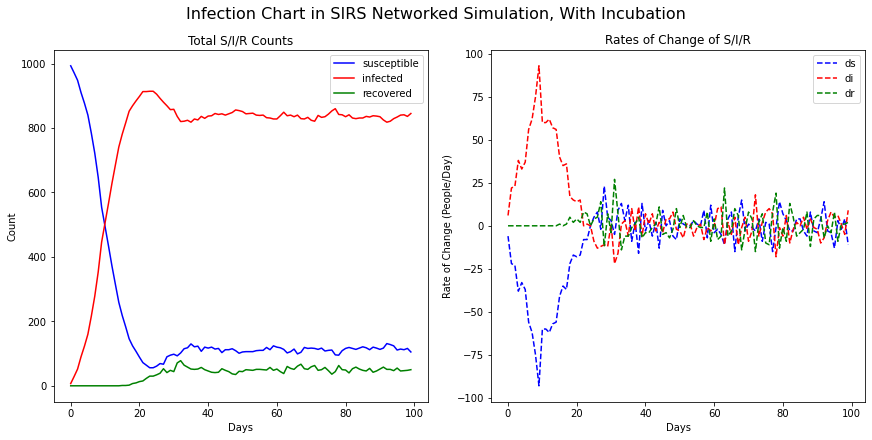

In [0]:
import os 
import random 
# Incubation Time version 
# can only heal after being undetected for certain number of timesteps 
lam.a = 0.1  # Set lambda to 0.5 
mu.a = 0.05 # Recovery Rate 
a.a = 0.5 # Recovered Users who become susceptible again 
INC_TIME = 14 # Incubation Time Step 

def do_incubation_simulation(g, PATIENT_ZEROS, state, lam, mu, a, pos, steps = 1000): 
    ''' 
    Resource: https://www.nature.com/articles/s41598-018-24648-w
    https://link.springer.com/chapter/10.1007/978-3-642-02466-5_78
    '''
    S = [1, 1, 1, 1] # Susceptible are white 
    I = [0, 0, 0, 1] # Infected are Black 
    R = [0.5, 0.5, 0.5, 1] # Recovered are Grey 

    # Set everyont to susceptible 
    for v in g.vertices(): 
        state[v] = S 

    inc_times= {} 

    # Infect Patients 0 
    for patient in PATIENT_ZEROS: 
        state[patient] = I
        inc_times[patient] = INC_TIME

    vs = g.get_vertices()
    def step(): 
        new_infects = set() 
        new_recovers = set() 
        new_susceptibles = set() 
        for v in vs: 
            if state[v] == I: 
                # try to infect edges 
                for edge in g.get_out_edges(v): 
                    if state[edge[-1]] == S: #if they are susceptible... 
                        if random.random() < lam[g.edge(*edge)]: 
                            new_infects.add(edge[-1])
                # try to heal 
                if inc_times[v] <= 0 and random.random() < mu[v]: 
                    new_recovers.add(v)
                inc_times[v] -= 1 
                
            # Recovered people might become susceptible.  
            if state[v] == R: 
                if random.random() < a[v]: 
                    new_susceptibles.add(v) 
        for v in new_infects: 
            inc_times[v] = INC_TIME 
            state[v] = I 
        for v in new_recovers: 
            state[v] = R 
        for v in new_susceptibles: 
            state[v] = S 
        return new_susceptibles, new_infects, new_recovers 
    
    # save animation 
    # if not os.path.exists("./frames"): 
    #     os.mkdir("./frames")

    counts = np.zeros((steps, 3)) 
    
    ds = []
    di = []
    dr = []
    for s in range(steps): 
        new_sus, new_inf, new_rec = step() 
        counts[s, 0] = sum(1 for v in g.get_vertices() if state[v] == S)
        counts[s, 1] = sum(1 for v in g.get_vertices() if state[v] == I)
        counts[s, 2] = sum(1 for v in g.get_vertices() if state[v] == R)
        ds.append(len(new_sus) - len(new_inf))
        di.append(len(new_inf) - len(new_rec))
        dr.append(len(new_rec) - len(new_sus))
    
    return counts, np.stack((ds, di, dr), axis=1)

counts, dcounts = do_incubation_simulation(g, [0], state, lam, mu, a, pos, 100)

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 6), constrained_layout="True") 
x = list(range(100)) 
ax1.plot(x, counts[:, 0], 'b-', label="susceptible")
ax1.plot(x, counts[:, 1], 'r-', label="infected")
ax1.plot(x, counts[:, 2], 'g-', label="recovered")
ax1.legend();
ax2.plot(x, dcounts[:, 0], 'b--', label='ds')
ax2.plot(x, dcounts[:, 1], 'r--', label='di')
ax2.plot(x, dcounts[:, 2], 'g--', label="dr")
ax2.legend() 

fig.suptitle("Infection Chart in SIRS Networked Simulation, With Incubation", fontsize=16)
ax1.set_title("Total S/I/R Counts") 
ax1.set_xlabel("Days") 
ax1.set_ylabel("Count") 

ax2.set_title("Rates of Change of S/I/R")
ax2.set_xlabel("Days") 
ax2.set_ylabel("Rate of Change (People/Day)");

# Influence Models

# Predictive Models


In [0]:
g = barabasi_albert.copy()
activation_probs = g.new_edge_property("double")
activation_probs.set_value(0.25)

def independent_cascade(graph, seed_nodes, steps=0):
    """Returns the active nodes of each diffusion step by the independent cascade model

    Parameters
    ----------
    graph: graph_tool graph
    seed_nodes: list of nodes in the graph to start diffusion
    steps: integer for number of steps to run diffusion

    Returns
    -------
    layer_i_nodes: list of list of activated nodes
        layer_i_nodes[0]: seed_nodes
        layer_i_nodes[k]: nodes activated at kth diffusion step
    
    """
    
    for node in seed_nodes:
        if node not in graph.vertices():
            raise Exception(f"Seed node {node} not in graph")

    g = Graph(graph)
    g.set_directed(True)

    # run diffusion
    a = [s for s in seed_nodes]
    if steps <= 0:
        return _diffuse_all(g, a)
    return _diffuse_k_rounds(g, a, steps)

def _diffuse_all(g, a):
    tried_edges = set()
    layer_i_nodes = []
    layer_i_nodes.append([i for i in a])
    while True:
        len_old = len(a)
        a, activated_nodes, curr_tried_edges = _diffuse_one_round(g, a, tried_edges)
        layer_i_nodes.append(activated_nodes)
        tried_edges = tried_edges.union(curr_tried_edges)
        if len(a) == len_old:
            break
    return layer_i_nodes

def _diffuse_k_rounds(g, a, steps):
    tried_edges = set()
    layer_i_nodes = []
    layer_i_nodes.append([i for i in a])
    while steps > 0 and len(a) < len(g.nodes()):
        len_old = len(a)
        a, activated_nodes, curr_tried_edges = _diffuse_one_round(g, a, tried_edges)
        layer_i_nodes.append(activated_nodes)
        tried_edges = tried_edges.union(curr_tried_edges)
        if len(a) == len_old:
            break
        steps -= 1
    return layer_i_nodes

def _diffuse_one_round(g, a, tried_edges):
    activated_nodes = set()
    curr_tried_edges = set()
    for node in a:
        for nb in node.out_neighbors():
            if nb in a or (node, nb) in tried_edges or (node, nb) in curr_tried_edges:
                continue
            if _prop_success(g, node, nb):
                activated_nodes.add(nb)
            curr_tried_edges.add((node, nb))
    activated_nodes = list(activated_nodes)
    a.extend(activated_nodes)
    return a, activated_nodes, curr_tried_edges

def _prop_success(g, src, dest):
    edge = g.edge(src, dest)
    if edge is None:
        return False
    return random.random() <= activation_probs[edge]

In [0]:
num_seeds = 25

seed_nodes = random.choices([n for n in g.vertices()], k=num_seeds)
layer_i_nodes = independent_cascade(g, seed_nodes)

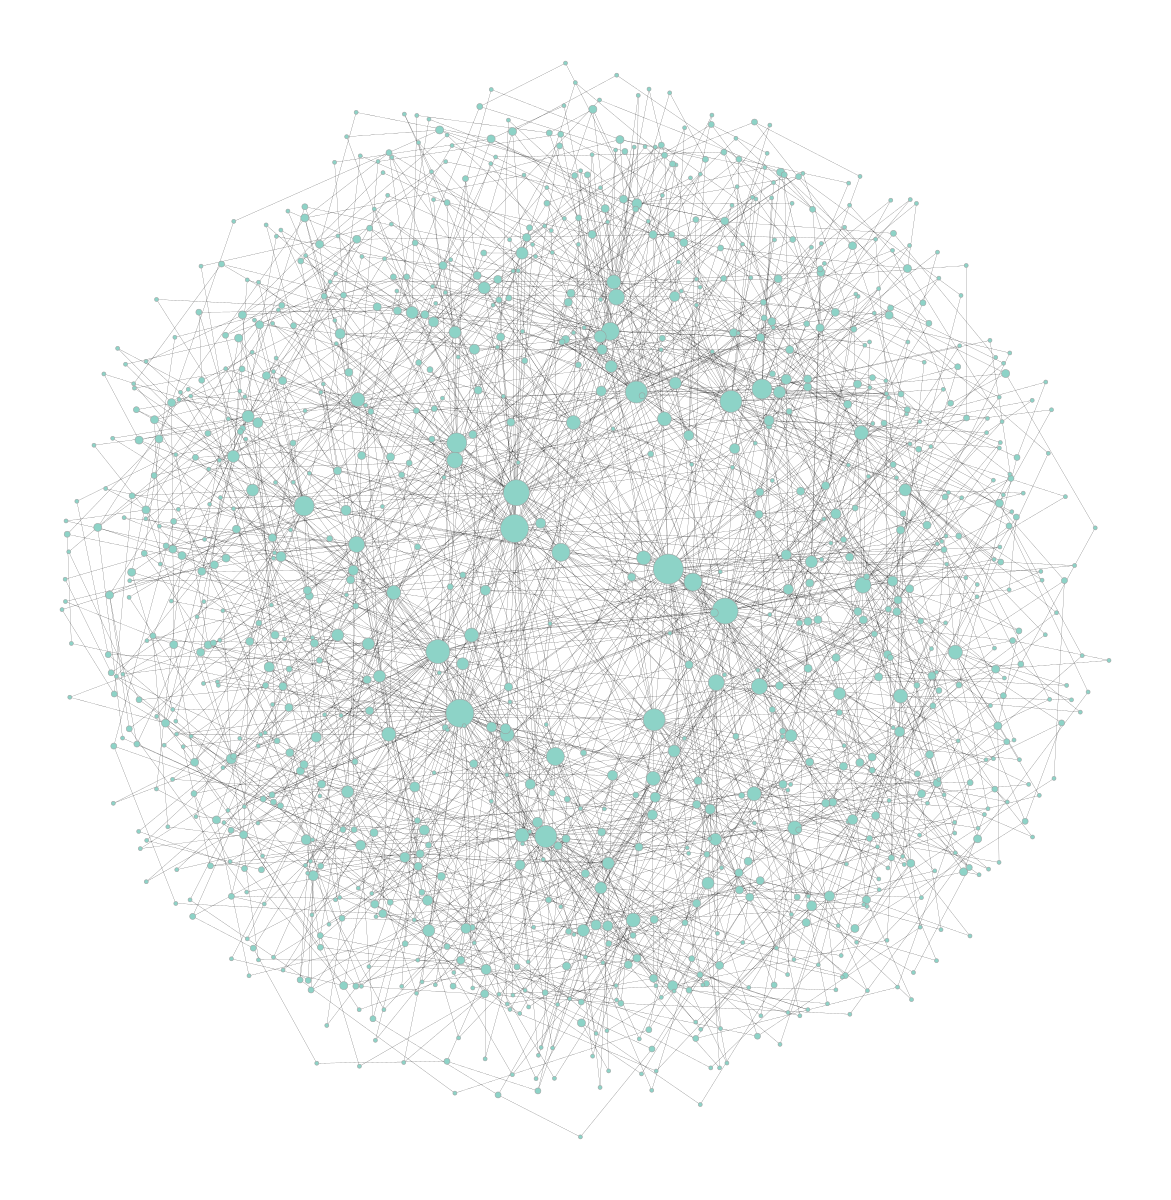

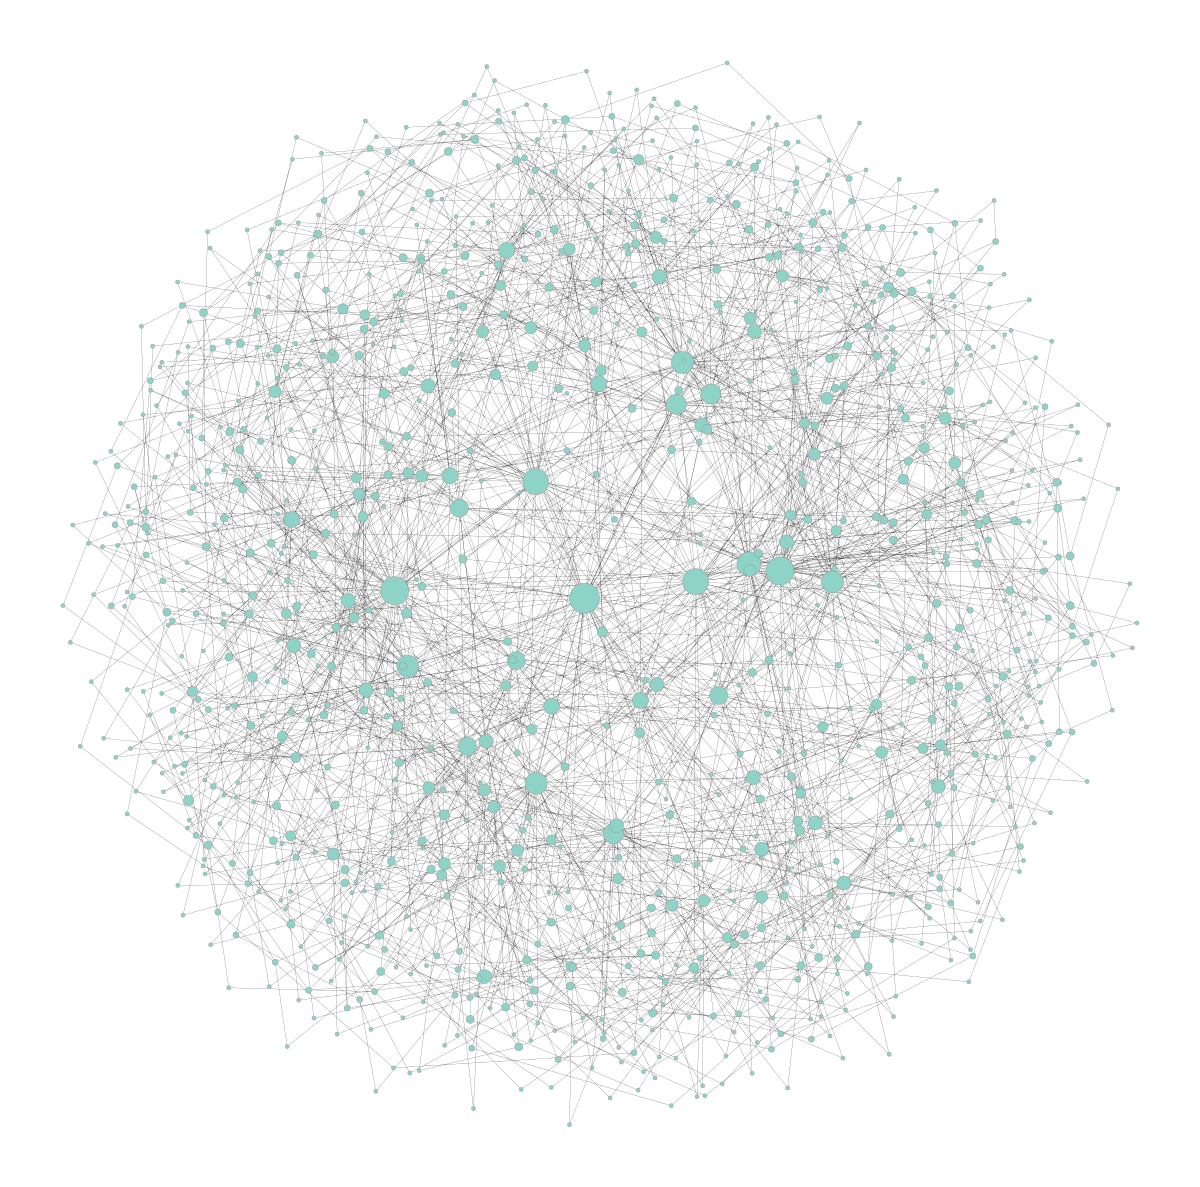

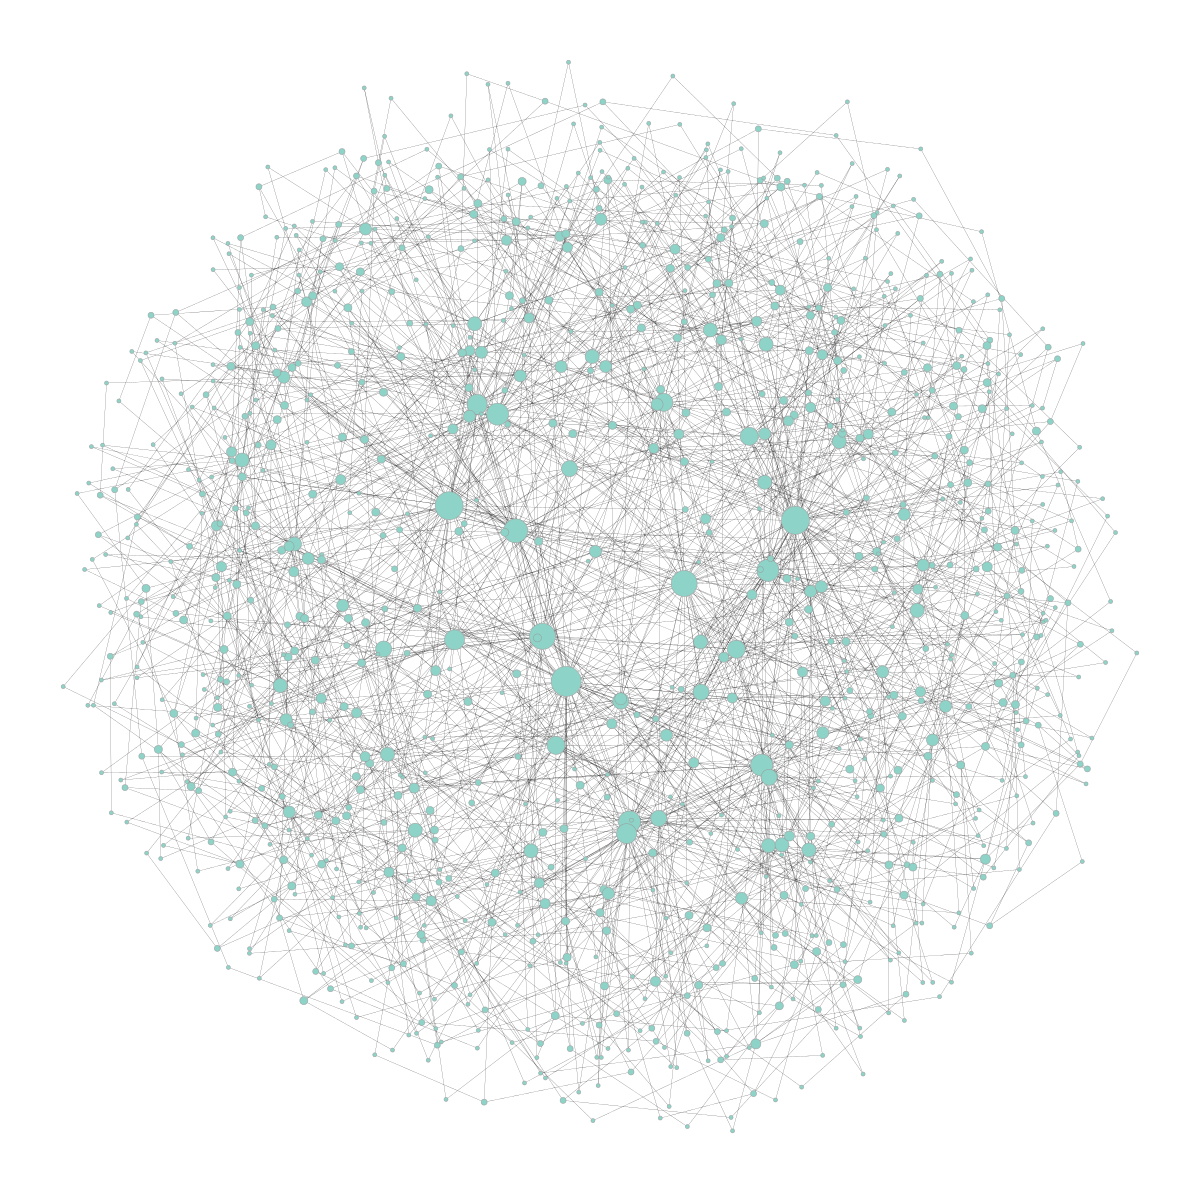

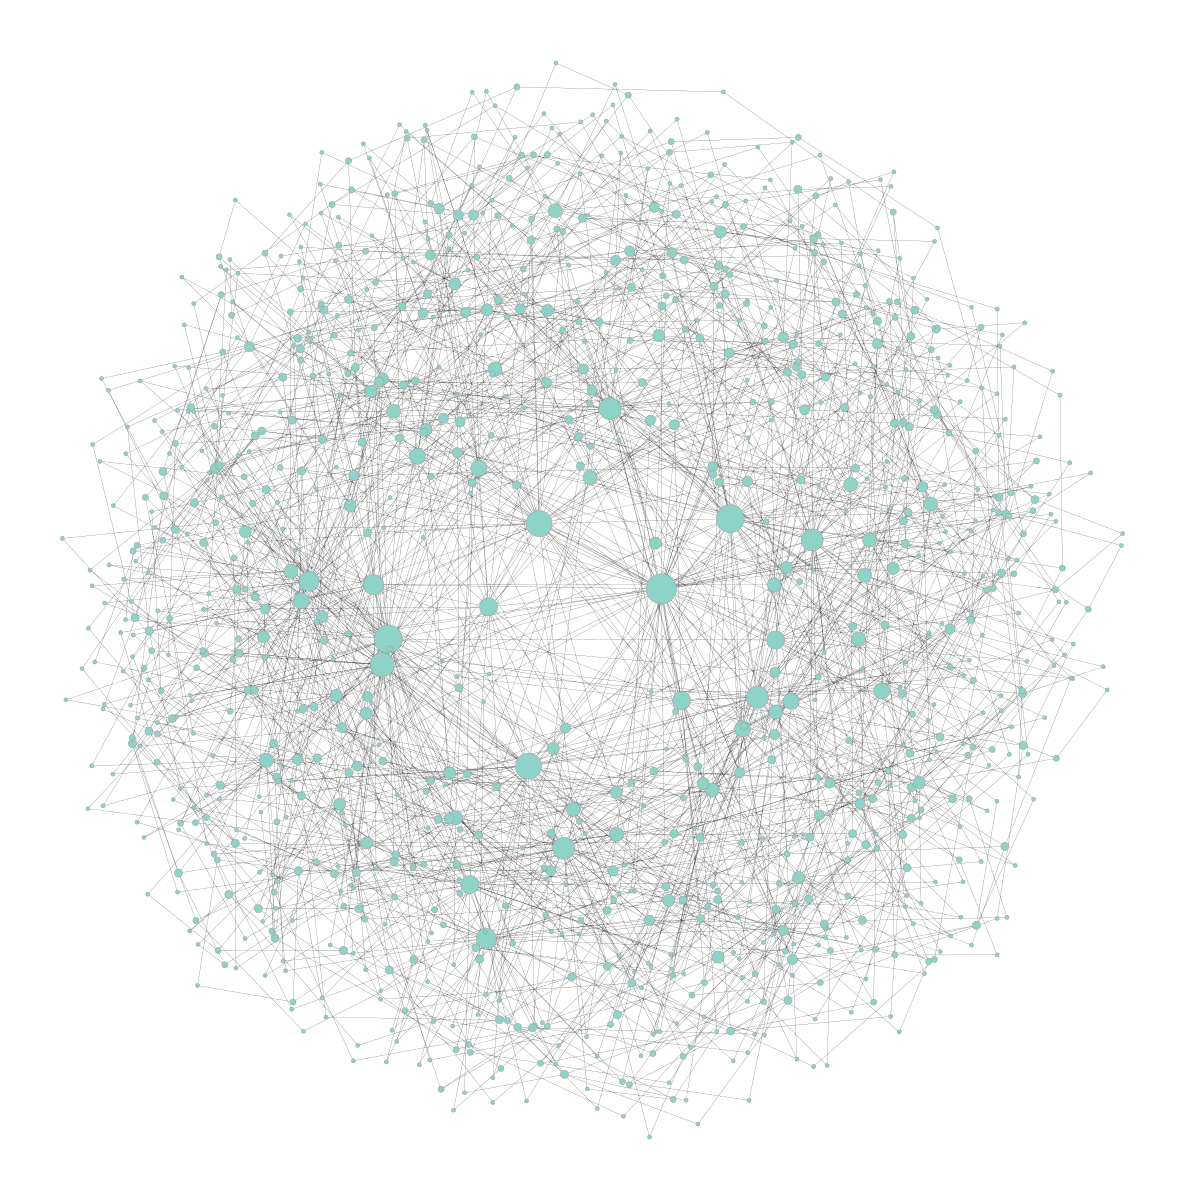

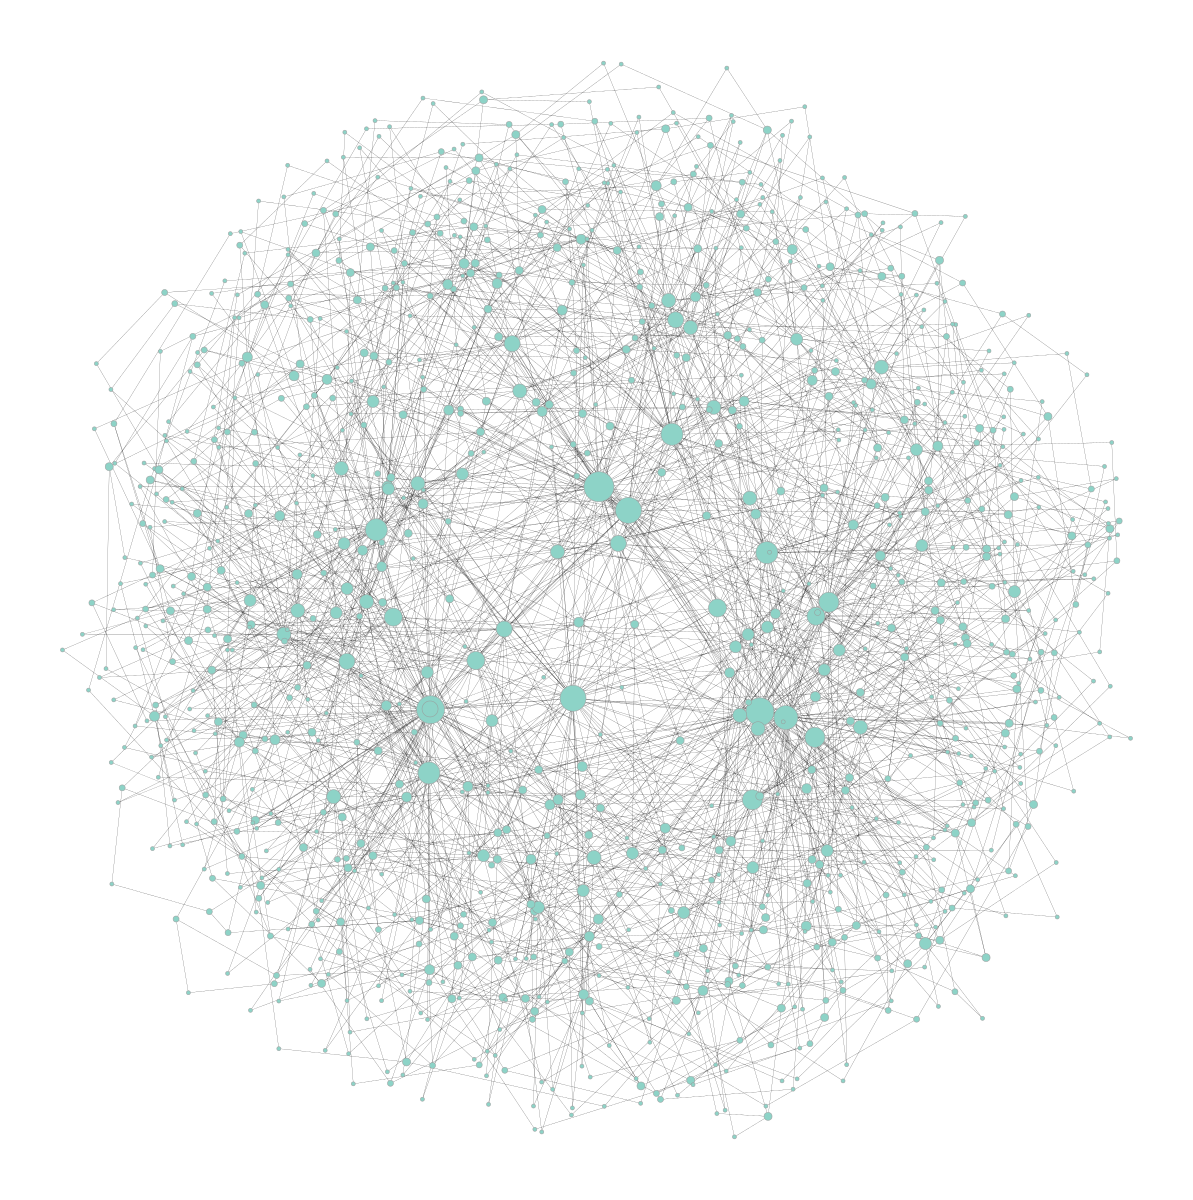

In [0]:
for step in layer_i_nodes:
    gd = g.copy()
    active = gd.new_vertex_property("bool")
    draw_graph(gd, vertex_fill_color=active)